# Tarea INFO286: Minería de Procesos

Integrantes: Felipe Córdova y Javier Reyes  
Profesor: Juan Salazar  
Fecha: 09/05/2025  


## Resumen

En este trabajo se analiza el log de eventos `traffic_fines`, el cual representa el proceso de gestión de multas de tránsito en Italia. Se utilizaron herramientas del ecosistema `bupaR` en R para explorar el log, visualizar el proceso, responder preguntas específicas y proponer mejoras. Se identificaron cuellos de botella, variantes comunes y actividades críticas. Entre los principales hallazgos destacan demoras considerables en ciertas etapas y la existencia de múltiples variantes del proceso. Se proponen dos mejoras orientadas a reducir tiempos muertos y simplificar el flujo de actividades.


### Instalación y carga de paquetes

In [153]:
# Instalar los paquetes solo la primera vez:
# install.packages("bupaR")
# install.packages("eventdataR")  # contiene el log traffic_fines
# install.packages("edeaR")       # análisis exploratorio
# install.packages("processmapR") # mapas de proceso
# install.packages("processmonitR") # monitoreo

# Cargar los paquetes:
library(bupaR)
library(eventdataR)
library(edeaR)
library(processmapR)
library(processmonitR)
library(ggplot2)

### Cargar y explorar el log *traffic_fines*

In [154]:
data("traffic_fines")

Cambiamos el nombre de nuestro log de `traffic_fines` a `data` para mas comodidad.

In [155]:
data <- traffic_fines

## 1. Descripción general del log

En esta sección se realiza una revisión exploratoria de los datos del proceso, identificando aspectos clave como la cantidad de casos, el número de actividades distintas, las ventanas de tiempo involucradas, la duración de los casos, la cantidad y distribución de variantes, así como los participantes que intervienen en el proceso.

Dado que el log ya ha sido cargado, procedemos a presentar un resumen general de los datos.

In [156]:
# Resumen general del log
summary(data)

Number of events:  34724
Number of cases:  10000
Number of traces:  44
Number of distinct activities:  11
Average trace length:  3.4724

Start eventlog:  2006-06-17
End eventlog:  2012-03-26



   case_id                                activity        lifecycle    
 Length:34724       Create Fine               :10000   complete:34724  
 Class :character   Send Fine                 : 6570                   
 Mode  :character   Payment                   : 4910                   
                    Add penalty               : 4635                   
                    Insert Fine Notification  : 4635                   
                    Send for Credit Collection: 3387                   
                    (Other)                   :  587                   
    resource       timestamp                         amount         
 559    : 1278   Min.   :2006-06-17 00:00:00.00   Length:34724      
 557    : 1181   1st Qu.:2007-07-19 00:00:00.00   Class :character  
 541    : 1119   Median :2007-10-29 00:00:00.00   Mode  :character  
 561    : 1002   Mean   :2007-12-06 15:34:51.32                     
 558    :  948   3rd Qu.:2008-02-29 00:00:00.00                     
 (Other): 

In [157]:
# Ver numero de actividades
n_activities(data)

[1] 11

In [158]:
# Ya sabemos que son 11 actividades, veamos cuales son
library(dplyr)

activity_labels(data) %>% 
  as.data.frame() %>% 
  tibble::as_tibble()  # Convertir en tibble para una mejor presentación

.
<fct>
Create Fine
Send Fine
Insert Fine Notification
Add penalty
Send for Credit Collection
Payment
Insert Date Appeal to Prefecture
Send Appeal to Prefecture
Receive Result Appeal from Prefecture


In [159]:
# Ventana de tiempo


In [160]:
# Duración de los casos

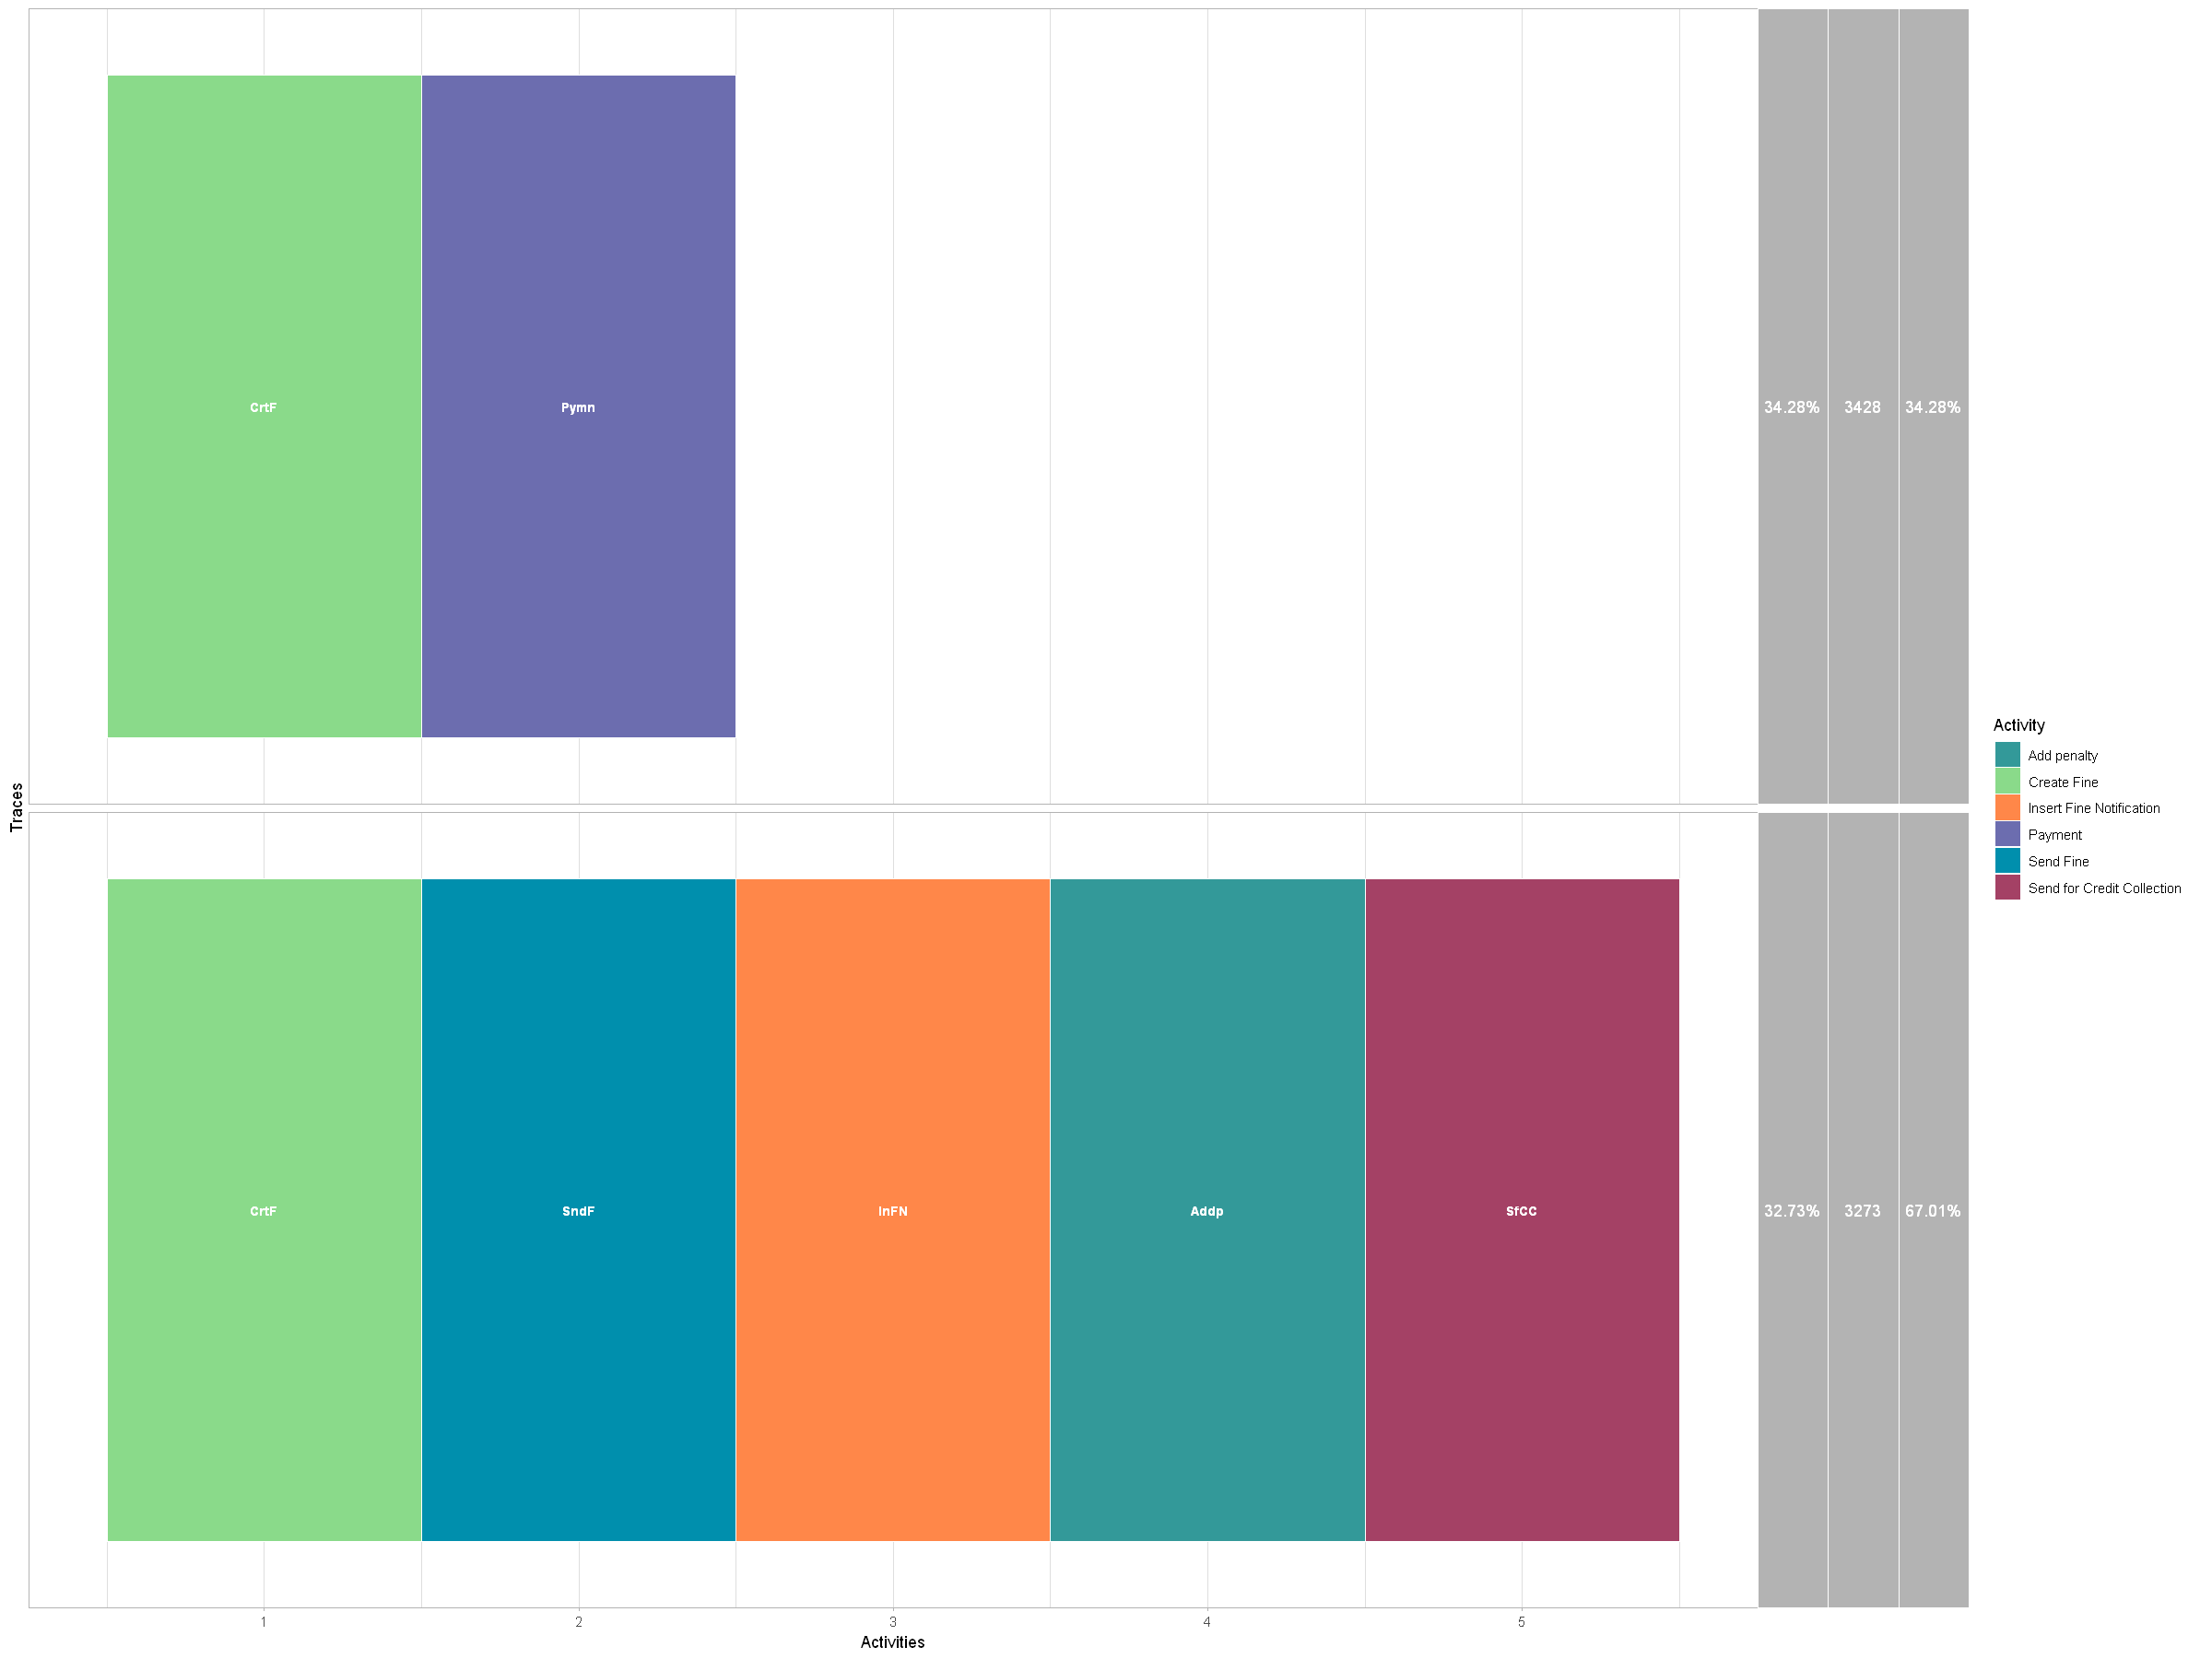

In [161]:
# Cantidad y distribución de variantes

data %>%
  trace_explorer(coverage = 0.5)

In [162]:
# Personas que participan en el proceso


### Descripción General 

| Información | Cantidad | 
| :--| :-- |
| Número de casos |  10000 casos |
| Número de actividades únicas | n actividades |
| Ventana de tiempo |  |
| Duración de los casos |  |
| Cantidad de variantes |  |
| Distribución de variantes |  |
| Personas / Roles que participan |  | 
| Con qué información se cuenta |  |
| Con qué información no se cuenta | 

## 2. Análisis del diagrama del proceso


## 3. Análisis del log mediante preguntas


## 4. Propuesta de mejoras al proceso


## Conclusión

Resumen de lo aprendido, limitaciones y posibles mejoras futuras del análisis.
